In [ ]:
!pip install opendatasets

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pagidipallyajaykumar
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption


100%|██████████| 11.4M/11.4M [00:00<00:00, 1.67GB/s]

In [ ]:
df = pd.read_csv("/content/hourly-energy-consumption/PJME_hourly.csv")

In [ ]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [ ]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [ ]:
df = df.set_index('Datetime')
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


<Axes: title={'center': 'PJME ENERGY USE IN MegaWatt'}, xlabel='Datetime'>

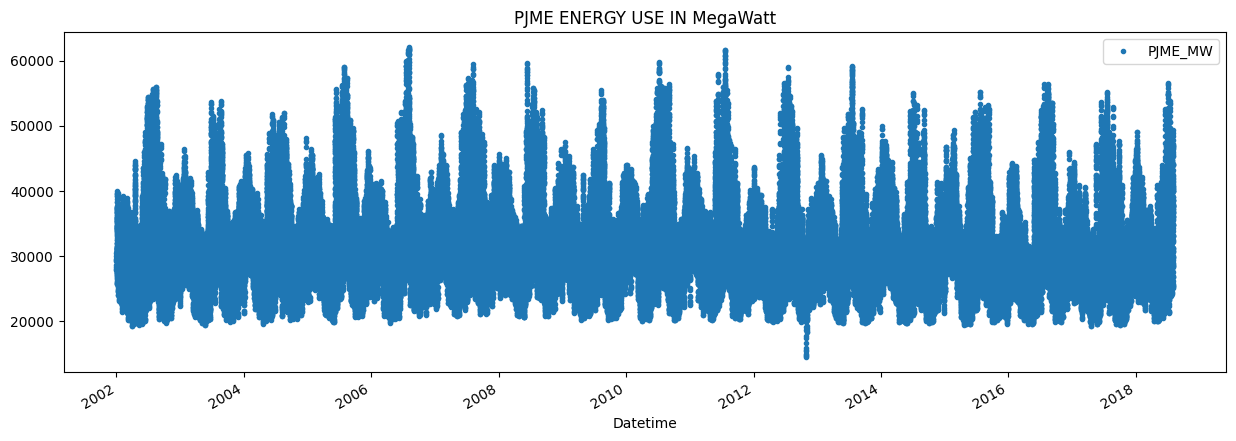

In [ ]:
df.plot(style='.',figsize=(15,5),title='PJME ENERGY USE IN MegaWatt')

In [ ]:
df.index = pd.to_datetime(df.index)

# Train/Test split

In [ ]:
train = df.loc[df.index<'01-01-2015']
test = df.loc[df.index>='01-01-2015']

- Visualization of train and test

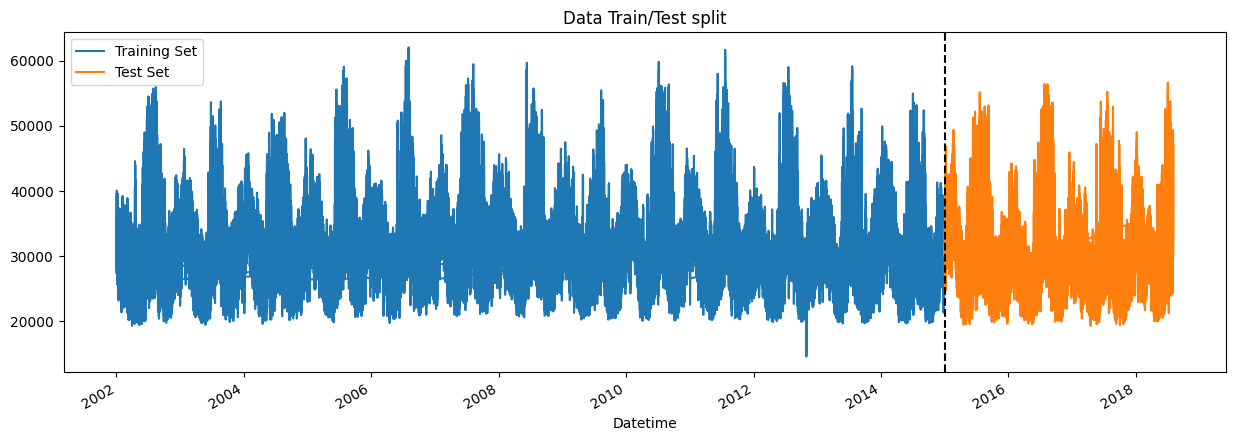

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training set',title='Data Train/Test split')
test.plot(ax=ax,label='Testing set')
ax.axvline('01-01-2015',color='black',ls='--')
ax.legend(['Training Set','Test Set'])
plt.show()

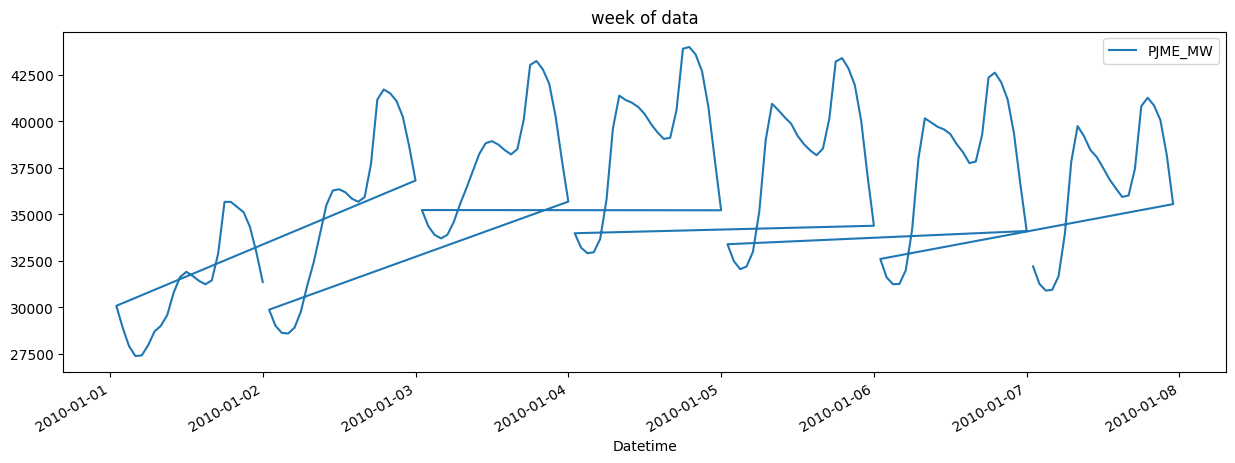

In [ ]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5),title='week of data')
plt.show()

# Feature Creation

In [ ]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.day_of_week

In [ ]:
df.head()

,PJME_MW,hour,dayofweek
Datetime,,,
2002-12-31 01:00:00,26498.0,1,1
2002-12-31 02:00:00,25147.0,2,1
2002-12-31 03:00:00,24574.0,3,1
2002-12-31 04:00:00,24393.0,4,1
2002-12-31 05:00:00,24860.0,5,1


In [ ]:
def create_features(df):
  #create time series features based on time series index
  df = df.copy()
  df['hour']=df.index.hour
  df['dayofweek']=df.index.dayofweek
  df['quarter']=df.index.quarter
  df['month']=df.index.month
  df['year']=df.index.year
  df['dayofyear']=df.index.dayofyear
  return df


In [ ]:
df = create_features(df)

In [ ]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


In [ ]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1
2018-01-01 23:00:00,40164.0,23,0,1,1,2018,1
2018-01-02 00:00:00,38608.0,0,1,1,1,2018,2


# Visualize our Feature / Target Relationship

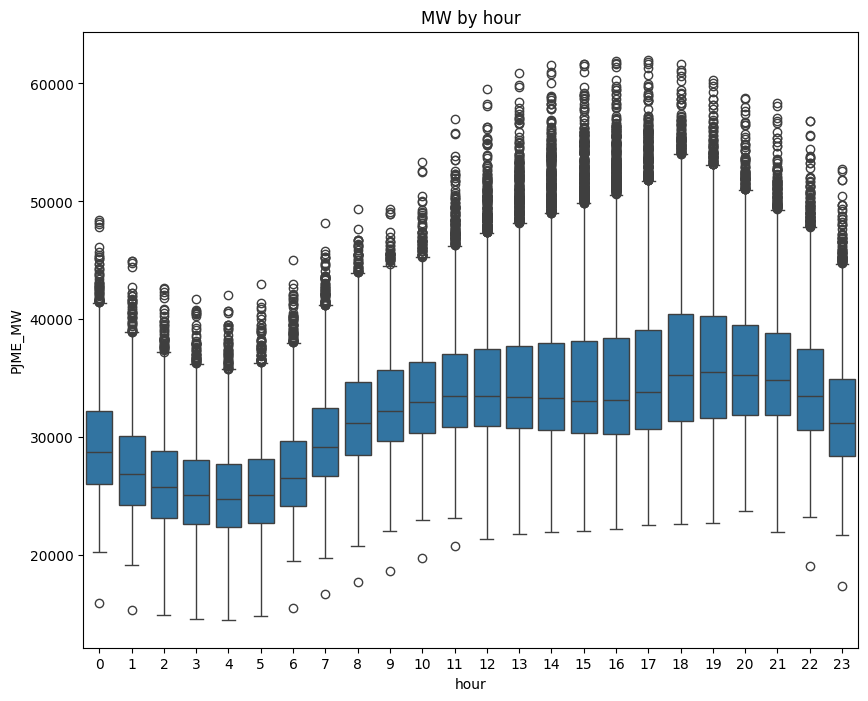

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='hour',y='PJME_MW')
ax.set_title('MW by hour')
plt.show()

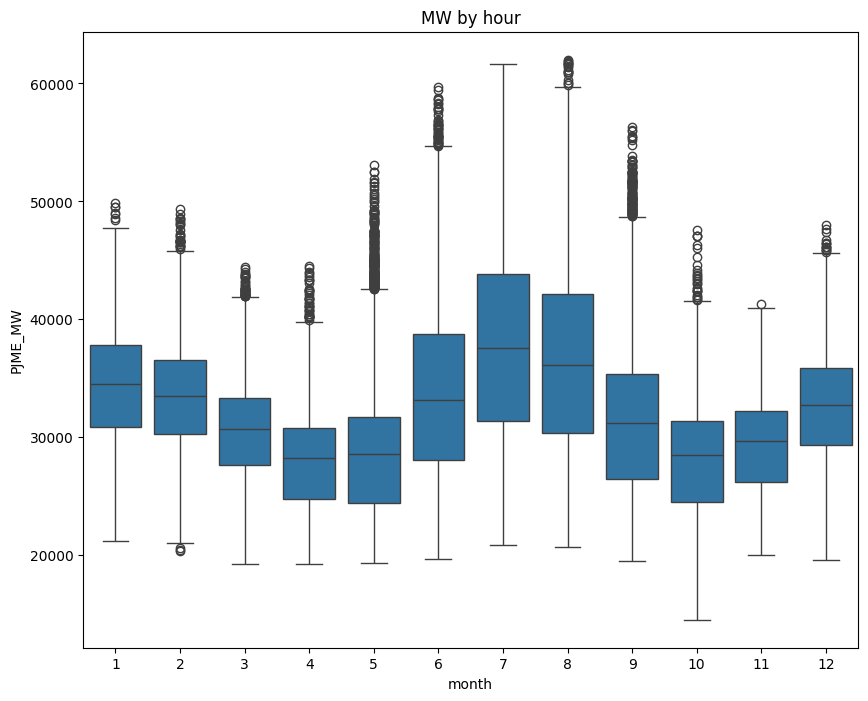

In [ ]:
fig,ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x='month',y='PJME_MW')
ax.set_title('MW by hour')
plt.show()

# Create our model

In [ ]:
train = create_features(train)
test = create_features(test)

# Features = []

/tmp/ipython-input-4081270970.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour']=df.index.hour
/tmp/ipython-input-4081270970.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dayofweek']=df.index.dayofweek
/tmp/ipython-input-4081270970.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

In [ ]:
train.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [ ]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
target = 'PJME_MW'

In [ ]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [ ]:
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.01)
reg.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[417]	validation_0-rmse:2801.66222	validation_1-rmse:3749.26089


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

# Feature Importance

In [ ]:
reg.feature_importances_

array([0.46387812, 0.1620048 , 0.02888114, 0.20316096, 0.02382433,
       0.11825063], dtype=float32)

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['Importance'])

In [ ]:
fi.head()

,Importance
hour,0.463878
dayofweek,0.162005
quarter,0.028881
month,0.203161
year,0.023824


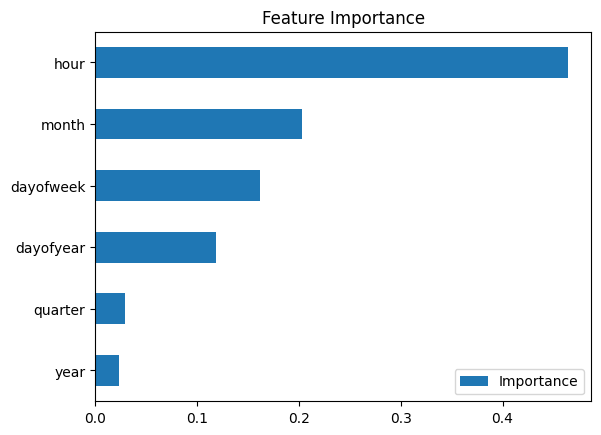

In [ ]:
fi.sort_values('Importance').plot(kind='barh',title='Feature Importance')
plt.show()

# Forecast on Test

In [ ]:
reg.predict(X_test)

array([32393.352, 29040.168, 27877.018, ..., 36229.527, 35141.754,
       32339.713], dtype=float32)

In [ ]:
test['prediction'] = reg.predict(X_test)

/tmp/ipython-input-2903689382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


In [ ]:
df = df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

In [ ]:
df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,NaN
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,38623.246094
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,38495.484375
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,36229.527344


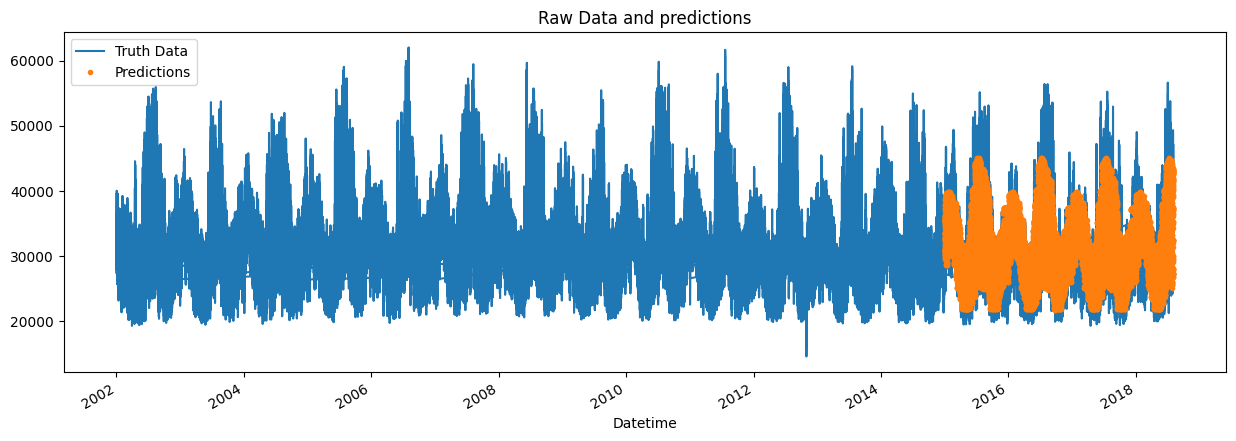

In [ ]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df.prediction.plot(ax=ax,style='.')
plt.legend(['Truth Data','Predictions'])
ax.set_title('Raw Data and predictions')
plt.show()

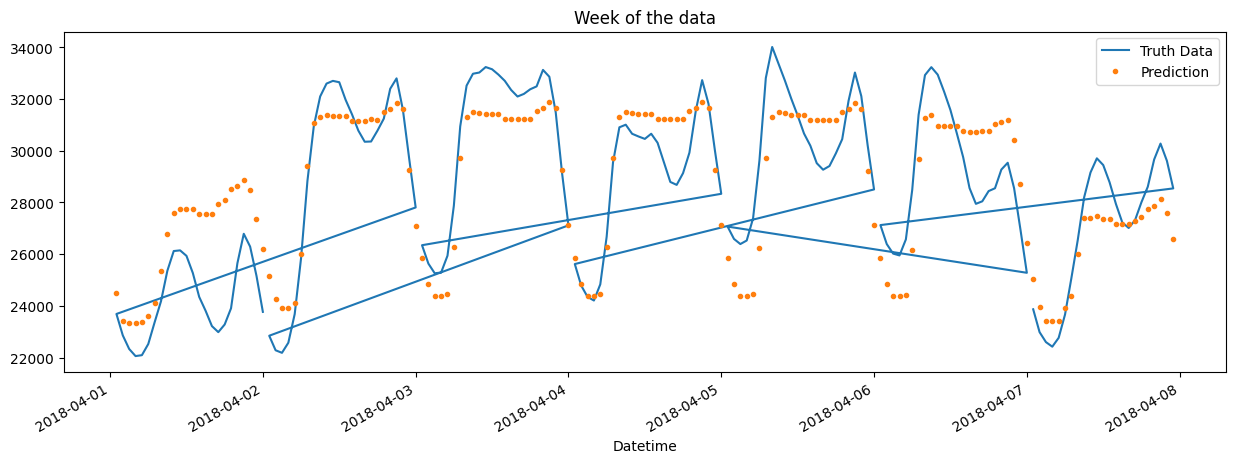

In [ ]:
ax = df.loc[(df.index>'04-01-2018')&(df.index<'04-08-2018')]['PJME_MW'].plot(figsize=(15,5),title='Week of the data')
df.loc[(df.index>'04-01-2018')&(df.index<'04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

# Metrics

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 3741.03


# Calculate Error
- Look at the worst and best predicted days

In [ ]:
test['error'] = np.abs(test[target]-test['prediction'])

/tmp/ipython-input-2731632443.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['error'] = np.abs(test[target]-test['prediction'])


In [ ]:
test.index.date